In [121]:
import pandas as pd
import seaborn as sns
import numpy as np
import geocoder
import gmaps
import statsmodels.api as sm

import pytz

import psycopg2

from sklearn.linear_model import Ridge

import spacy

import swifter

import matplotlib.patches as mpatches

import requests


In [122]:
# Plot settings
%pylab inline

figsize(15, 9)

import matplotlib.style as style

style.use('childsafeai')

Populating the interactive namespace from numpy and matplotlib


In [123]:
from local_settings import GOOGLE_API_KEY

gmaps.configure(GOOGLE_API_KEY)

# Tests

## Processing

In [124]:
tests = requests.get("https://covidtracking.com/api/states/daily").json()
tests_df = pd.DataFrame(tests)
tests_df

,date,state,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,...,hospitalized,total,totalTestResults,posNeg,fips,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
0,20200418,AK,314.0,9341.0,NaN,39.0,36.0,NaN,NaN,NaN,...,36.0,9655.0,9655.0,9655.0,02,0.0,0.0,200.0,5.0,205.0
1,20200418,AL,4655.0,37883.0,NaN,NaN,620.0,NaN,247.0,NaN,...,620.0,42538.0,42538.0,42538.0,01,2.0,26.0,4565.0,125.0,4690.0
2,20200418,AR,1739.0,22402.0,NaN,86.0,291.0,NaN,NaN,22.0,...,291.0,24141.0,24141.0,24141.0,05,1.0,291.0,603.0,44.0,647.0
3,20200418,AS,0.0,3.0,17.0,NaN,NaN,NaN,NaN,NaN,...,NaN,20.0,3.0,3.0,60,0.0,0.0,0.0,0.0,0.0
4,20200418,AZ,4719.0,46326.0,NaN,566.0,NaN,285.0,NaN,178.0,...,NaN,51045.0,51045.0,51045.0,04,8.0,0.0,1603.0,212.0,1815.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2447,20200301,MI,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,9.0,9.0,9.0,26,NaN,NaN,NaN,NaN,NaN
2448,20200301,RI,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1.0,1.0,1.0,44,NaN,NaN,NaN,NaN,NaN
2449,20200301,WA,30.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,30.0,30.0,30.0,53,3.0,0.0,0.0,12.0,12.0
2450,20200229,WA,18.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,18.0,18.0,18.0,53,1.0,0.0,0.0,9.0,9.0


In [125]:
tests_df['dateChecked'] = pd.to_datetime(tests_df['dateChecked'])
tests_df['Date'] = pd.to_datetime(tests_df['dateChecked'].dt.date)

In [126]:
tests_df[['positive', 'negative', 'pending', 'death', 'total']] = tests_df[['positive', 'negative', 'pending', 'death', 'total']].astype(int, errors='ignore')

In [127]:
tests_df['completed'] = tests_df['positive'] + tests_df['negative']

In [128]:
us_state_abbreviations = pd.read_csv('data/us_state_abbreviations.csv')
us_state_abbreviations = us_state_abbreviations.groupby('Abbreviation')['Full Name'].max().to_dict()
us_state_abbreviations[np.nan] = 'Unknown'
us_state_abbreviations['DC'] = 'District of Columbia'
us_state_abbreviations['AS'] = 'American Samoa'
us_state_abbreviations['GU'] = 'Guam'
us_state_abbreviations['MP'] = 'Marianas'
us_state_abbreviations['PR'] = 'Marianas'
us_state_abbreviations['VI'] = 'Virgin Island'

tests_df['State'] = tests_df['state'].map(lambda x: us_state_abbreviations[x] if not x == np.nan else x)
tests_df

,date,state,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,...,posNeg,fips,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease,Date,completed,State
0,20200418,AK,314.0,9341.0,NaN,39.0,36.0,NaN,NaN,NaN,...,9655.0,02,0.0,0.0,200.0,5.0,205.0,2020-04-18,9655.0,Alaska
1,20200418,AL,4655.0,37883.0,NaN,NaN,620.0,NaN,247.0,NaN,...,42538.0,01,2.0,26.0,4565.0,125.0,4690.0,2020-04-18,42538.0,Alabama
2,20200418,AR,1739.0,22402.0,NaN,86.0,291.0,NaN,NaN,22.0,...,24141.0,05,1.0,291.0,603.0,44.0,647.0,2020-04-18,24141.0,Arkansas
3,20200418,AS,0.0,3.0,17.0,NaN,NaN,NaN,NaN,NaN,...,3.0,60,0.0,0.0,0.0,0.0,0.0,2020-04-18,3.0,American Samoa
4,20200418,AZ,4719.0,46326.0,NaN,566.0,NaN,285.0,NaN,178.0,...,51045.0,04,8.0,0.0,1603.0,212.0,1815.0,2020-04-18,51045.0,Arizona
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2447,20200301,MI,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,9.0,26,NaN,NaN,NaN,NaN,NaN,2020-03-01,NaN,Michigan
2448,20200301,RI,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,44,NaN,NaN,NaN,NaN,NaN,2020-03-01,NaN,Rhode Island
2449,20200301,WA,30.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,30.0,53,3.0,0.0,0.0,12.0,12.0,2020-03-01,NaN,Washington
2450,20200229,WA,18.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,18.0,53,1.0,0.0,0.0,9.0,9.0,2020-02-29,NaN,Washington


In [129]:
state_populations = pd.read_excel('data/us_state_populations.xlsx')
tests_df['State Population'] = tests_df['State'].map(lambda x: state_populations[state_populations['State'] == x]['2020 Pop.\xa0'].sum())
tests_df['Tests per Capita'] = (tests_df['total'] / tests_df['State Population'])

In [130]:
%store tests_df

Stored 'tests_df' (DataFrame)


## Analysis

In [131]:
tests_df.groupby('Date')['completed'].sum().max()

3698534.0

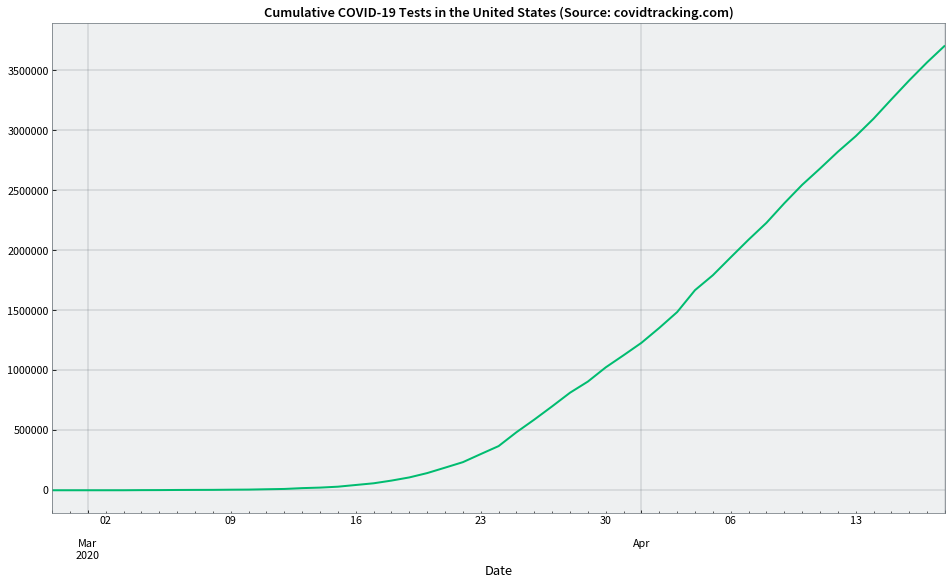

In [132]:
tests_df.groupby('Date')['total'].sum().plot(kind='line', 
                                                    title="Cumulative COVID-19 Tests in the United States (Source: covidtracking.com)")

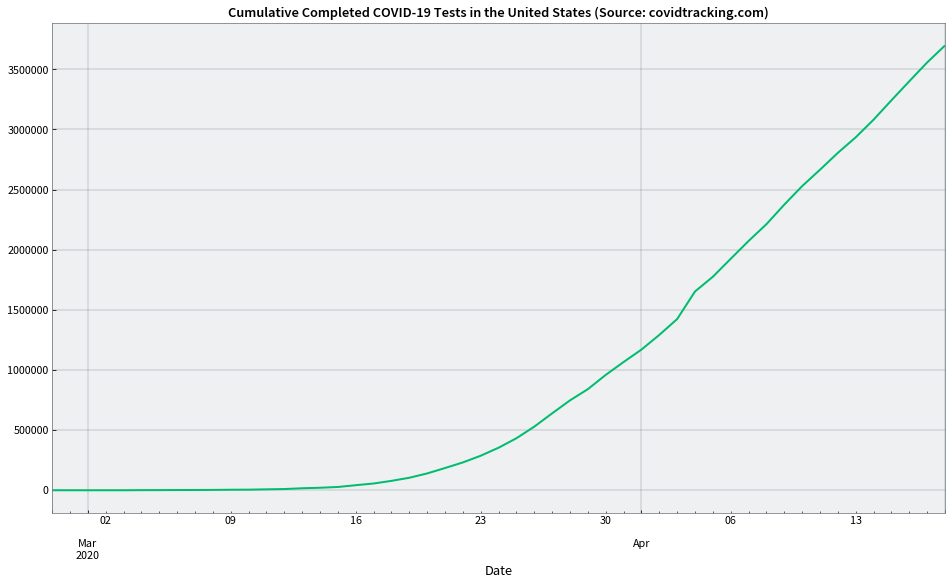

In [133]:
tests_df.groupby('Date')['completed'].sum().plot(kind='line', 
                                                    title="Cumulative Completed COVID-19 Tests in the United States (Source: covidtracking.com)")

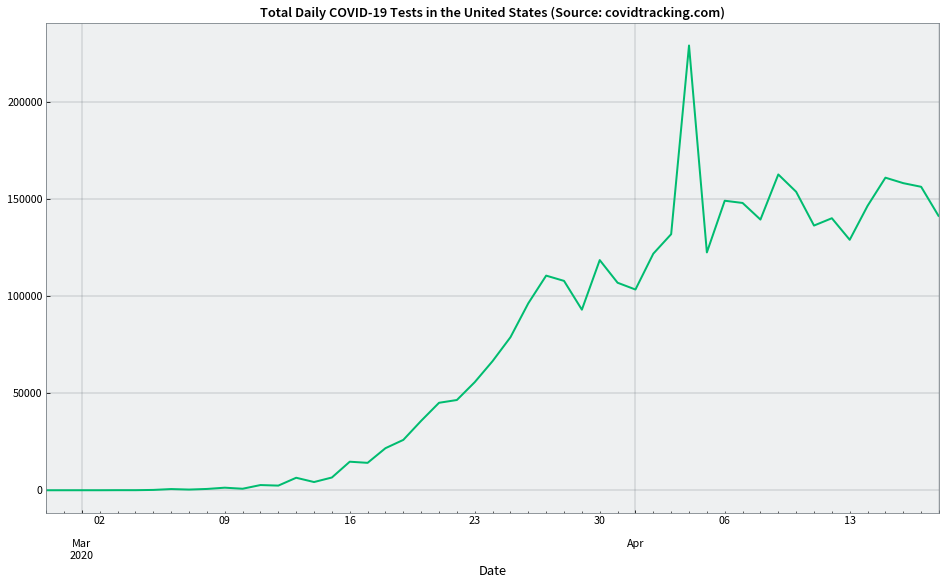

In [134]:
figsize(16, 9)
tests_df.groupby('Date')['totalTestResultsIncrease'].sum().plot(kind='line', 
                                                    title="Total Daily COVID-19 Tests in the United States (Source: covidtracking.com)")

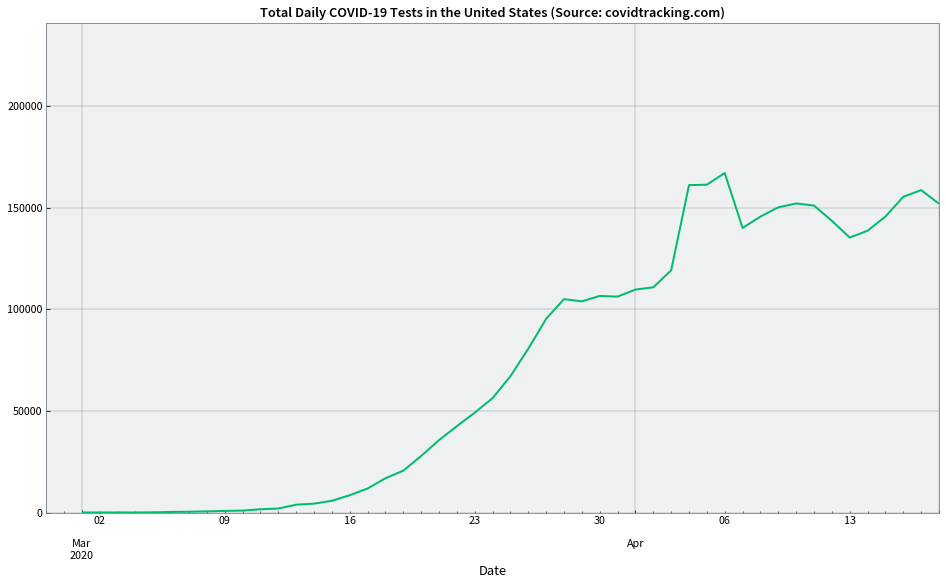

In [135]:
figsize(16, 9)

ax = tests_df.groupby('Date')['totalTestResultsIncrease'].sum().plot(kind='bar')
tests_df.groupby('Date')['totalTestResultsIncrease'].sum().rolling(3).mean().plot(kind='line', label="Rolling 3 Day Avg", ax=ax,
                                                                                       title="Total Daily COVID-19 Tests in the United States (Source: covidtracking.com)")
plt.show()

In [136]:
tests_df.dtypes

date                                      int64
state                                    object
positive                                float64
negative                                float64
pending                                 float64
hospitalizedCurrently                   float64
hospitalizedCumulative                  float64
inIcuCurrently                          float64
inIcuCumulative                         float64
onVentilatorCurrently                   float64
onVentilatorCumulative                  float64
recovered                               float64
hash                                     object
dateChecked                 datetime64[ns, UTC]
death                                   float64
hospitalized                            float64
total                                   float64
totalTestResults                        float64
posNeg                                  float64
fips                                     object
deathIncrease                           

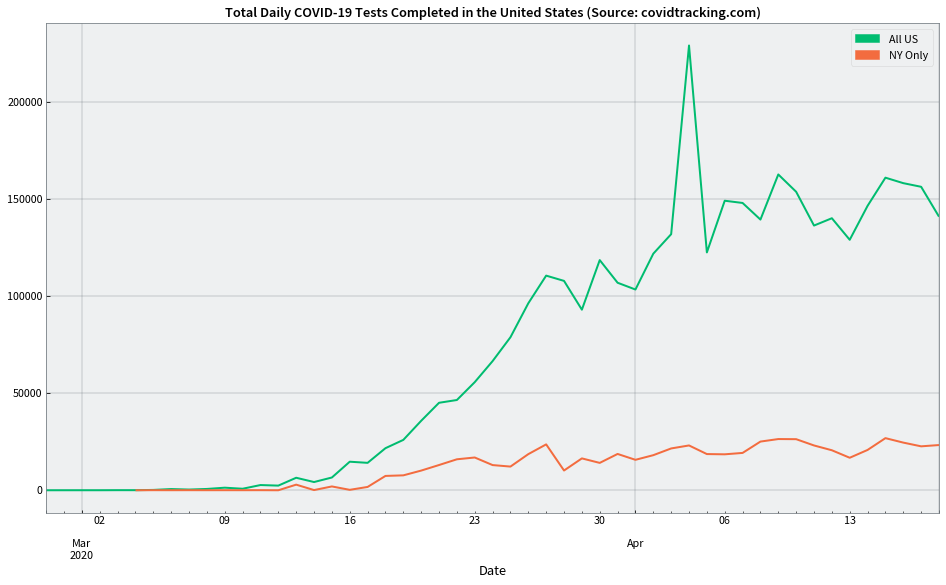

In [137]:
figsize(16, 9)
ax = tests_df.groupby('Date')['totalTestResultsIncrease'].sum().plot(kind='line', label="US",
                                                    title="Total Daily COVID-19 Tests Completed in the United States (Source: covidtracking.com)")

tests_df[tests_df['state'] == 'NY'].groupby(['Date', 'state'])['totalTestResultsIncrease'].sum().unstack('state').plot(kind='line', ax=ax)

ax.legend(handles=[mpatches.Patch(color="#00bc70", label="All US"),
                   mpatches.Patch(color="#f36c3f", label="NY Only")])

In [138]:
tests_df[tests_df['Date'] >= '2020-03-23'].groupby('Date')['total'].sum().diff().mean()

131024.73076923077

In [139]:
tests_df[(tests_df['state'] == 'NY') & (tests_df['Date'] >= '2020-03-23')].groupby('Date')['total'].sum().diff().mean()

19932.423076923078

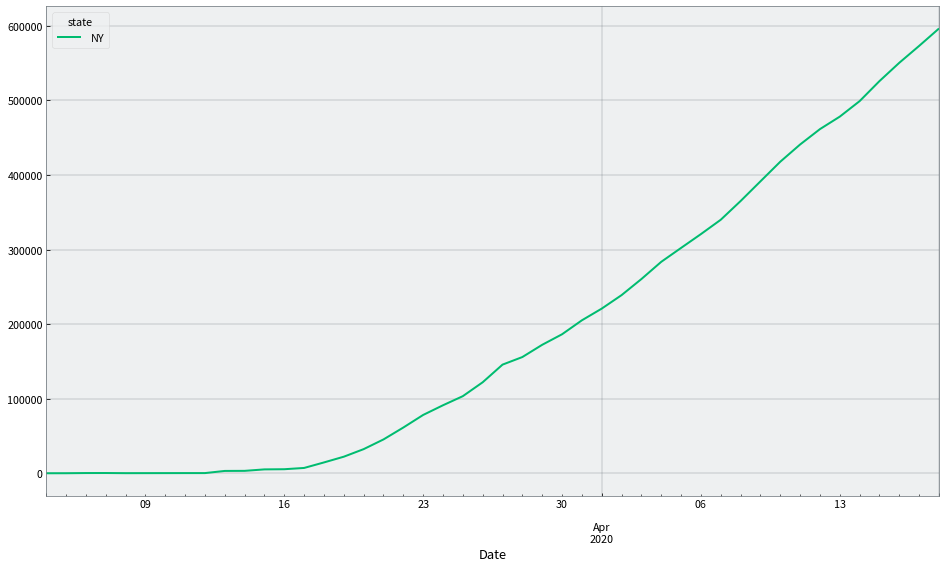

In [140]:
tests_df[tests_df['state'] == 'NY'].groupby(['Date', 'state'])['total'].max().unstack('state').plot(kind='line')

In [141]:
tests_df[tests_df['state'] == 'NY'].groupby('Date')['death'].max().diff()

Date
2020-03-04      NaN
2020-03-05      NaN
2020-03-06      NaN
2020-03-07      NaN
2020-03-08      NaN
2020-03-09      NaN
2020-03-10      NaN
2020-03-11      NaN
2020-03-12      NaN
2020-03-13      NaN
2020-03-14      NaN
2020-03-15      NaN
2020-03-16      4.0
2020-03-17      0.0
2020-03-18      5.0
2020-03-19      0.0
2020-03-20     23.0
2020-03-21      9.0
2020-03-22     70.0
2020-03-23      0.0
2020-03-24     96.0
2020-03-25     75.0
2020-03-26    100.0
2020-03-27    134.0
2020-03-28    209.0
2020-03-29    237.0
2020-03-30    253.0
2020-03-31    332.0
2020-04-01    391.0
2020-04-02    432.0
2020-04-03    562.0
2020-04-04    630.0
2020-04-05    594.0
2020-04-06    599.0
2020-04-07    731.0
2020-04-08    779.0
2020-04-09    799.0
2020-04-10    777.0
2020-04-11    783.0
2020-04-12    758.0
2020-04-13    671.0
2020-04-14    778.0
2020-04-15    752.0
2020-04-16    606.0
2020-04-17    630.0
2020-04-18    540.0
Name: death, dtype: float64

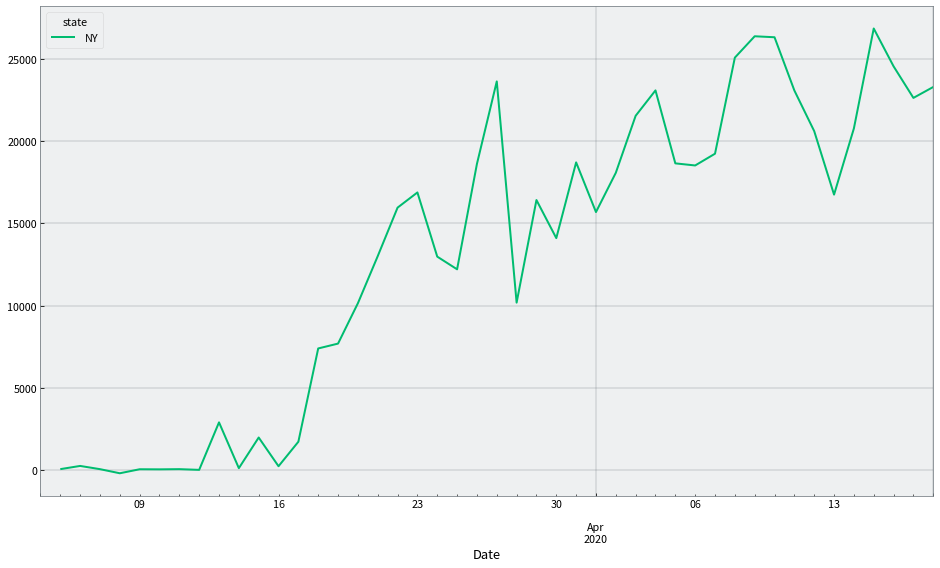

In [142]:
tests_df[tests_df['state'] == 'NY'].groupby(['Date', 'state'])['total'].max().diff().unstack('state').plot(kind='line')

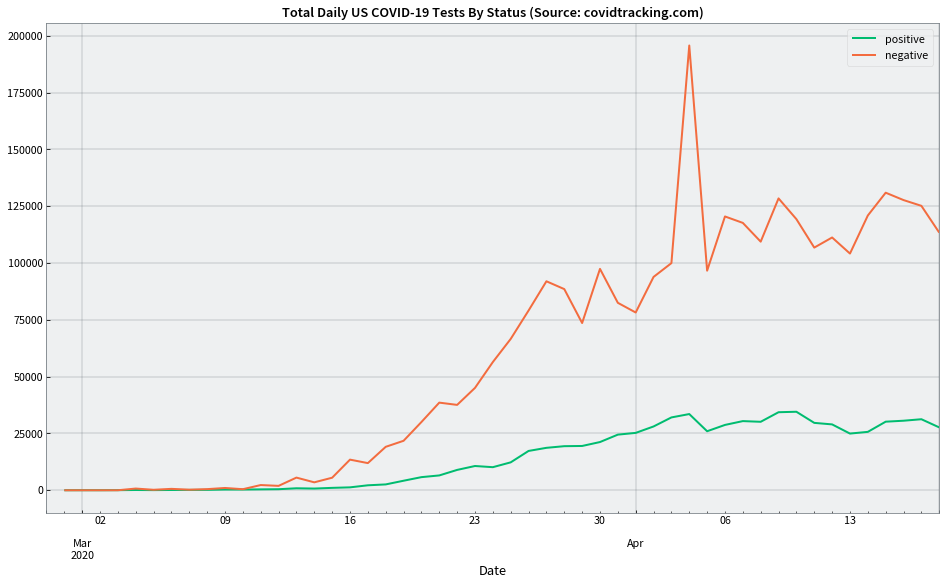

In [143]:
tests_df.groupby('Date')[['positive', 'negative']].sum().diff().plot(kind='line', 
                                                                     title="Total Daily US COVID-19 Tests By Status (Source: covidtracking.com)")

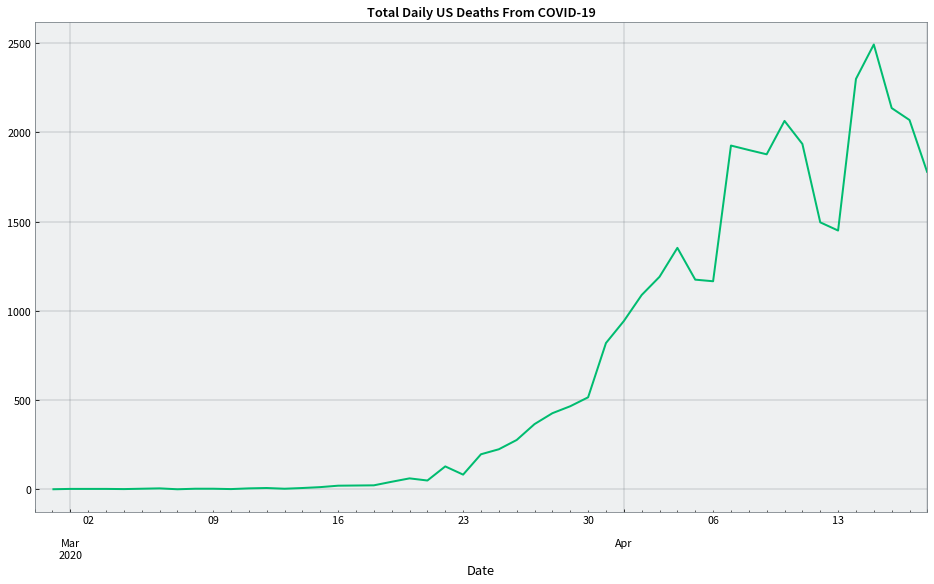

In [144]:
tests_df.groupby('Date')['death'].sum().diff().plot(kind='line',
                                                    title="Total Daily US Deaths From COVID-19")

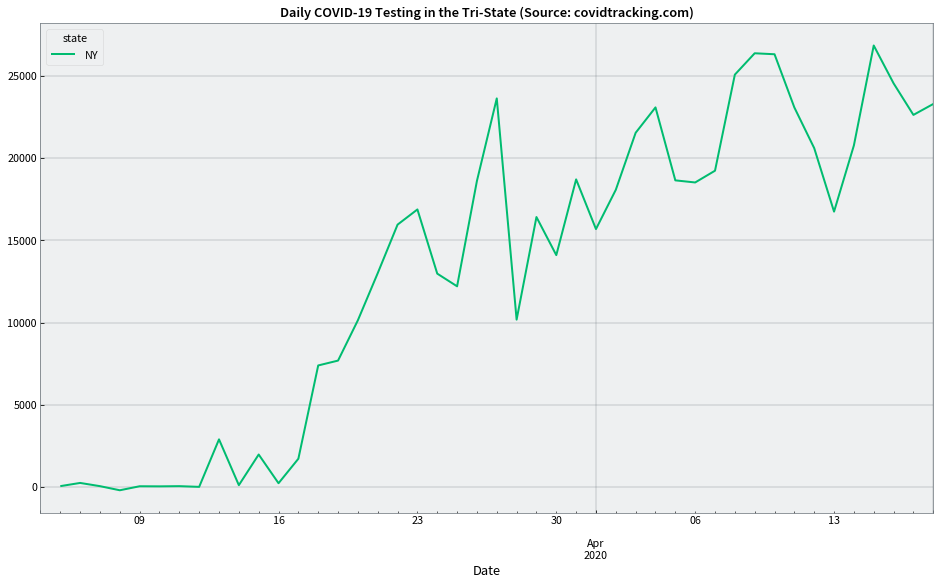

In [145]:
figsize(16, 9)
tests_df[tests_df['state'].isin(['NY'])].groupby(['Date', 'state'])['total'].max().diff().unstack('state').plot(kind='line',
                                                                                                                     title="Daily COVID-19 Testing in the Tri-State (Source: covidtracking.com)")

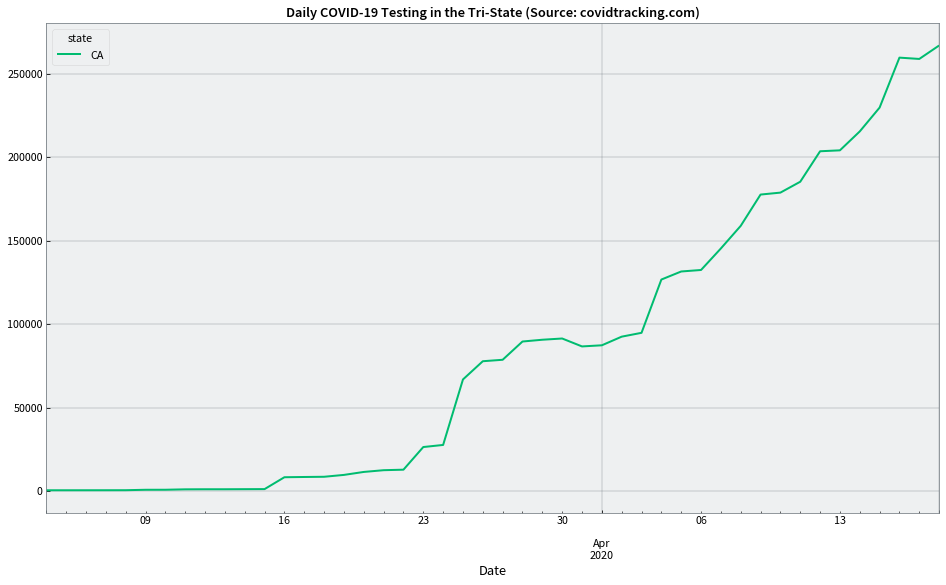

In [146]:
figsize(16, 9)
tests_df[tests_df['state'].isin(['CA'])].groupby(['Date', 'state'])['total'].sum().unstack('state').plot(kind='line',
                                                                                                                     title="Daily COVID-19 Testing in the Tri-State (Source: covidtracking.com)")

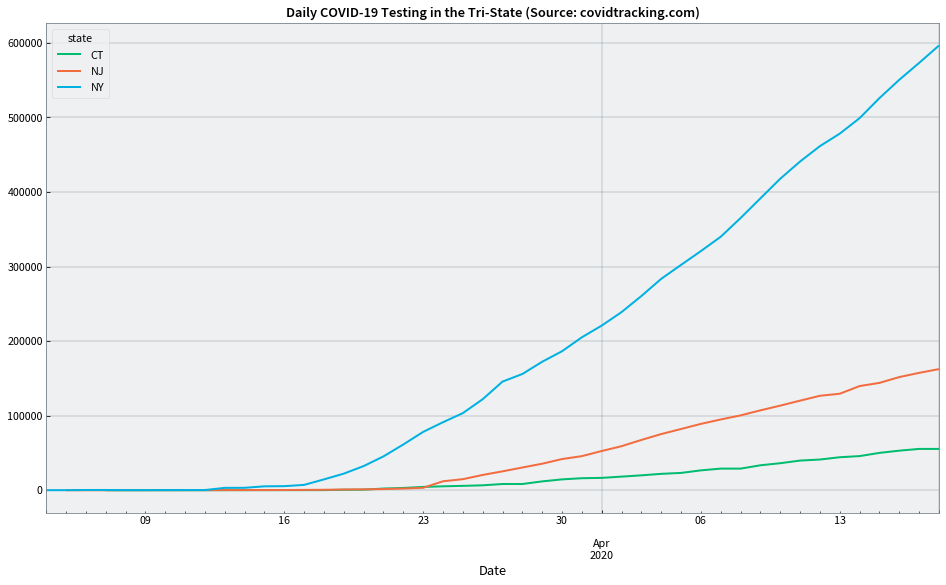

In [147]:
figsize(16, 9)
tests_df[tests_df['state'].isin(['NY', 'CT', 'NJ'])].groupby(['Date', 'state'])['total'].max().unstack('state').plot(kind='line',
                                                                                                                     title="Daily COVID-19 Testing in the Tri-State (Source: covidtracking.com)")

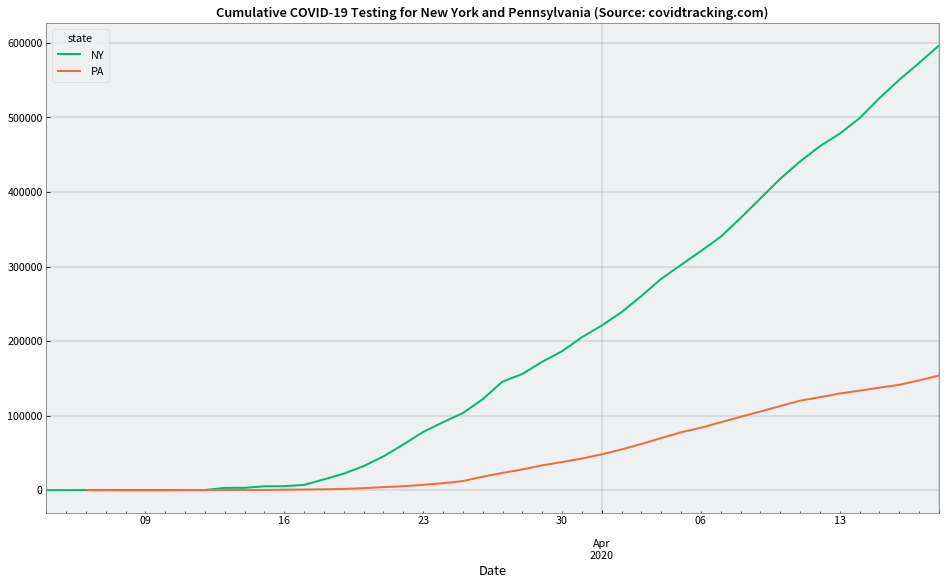

In [148]:
figsize(16, 9)
tests_df[tests_df['state'].isin(['NY', 'PA'])].groupby(['Date', 'state'])['total'].max().unstack('state').plot(kind='line',
                                                                                                                     title="Cumulative COVID-19 Testing for New York and Pennsylvania (Source: covidtracking.com)")

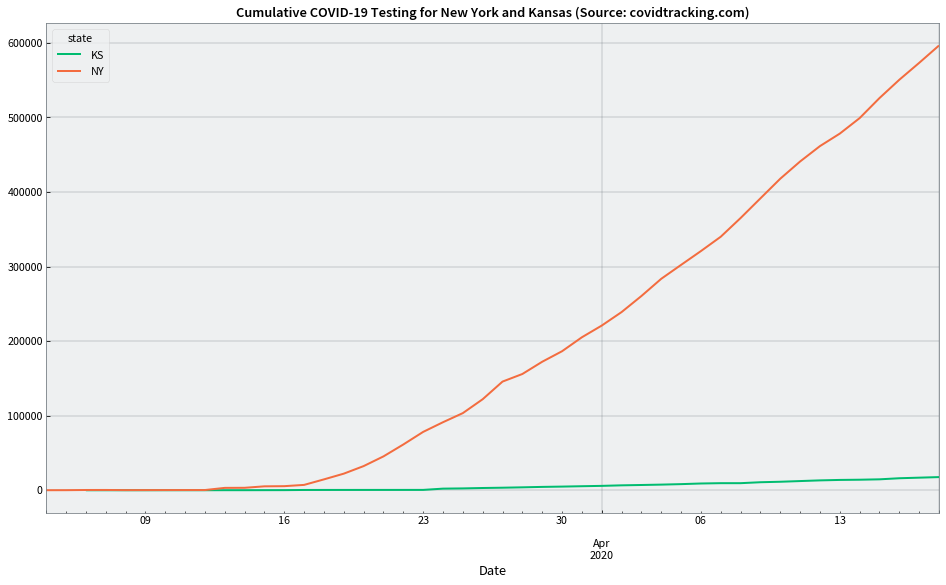

In [149]:
figsize(16, 9)
tests_df[tests_df['state'].isin(['NY', 'KS'])].groupby(['Date', 'state'])['total'].max().unstack('state').plot(kind='line',
                                                                                                                     title="Cumulative COVID-19 Testing for New York and Kansas (Source: covidtracking.com)")

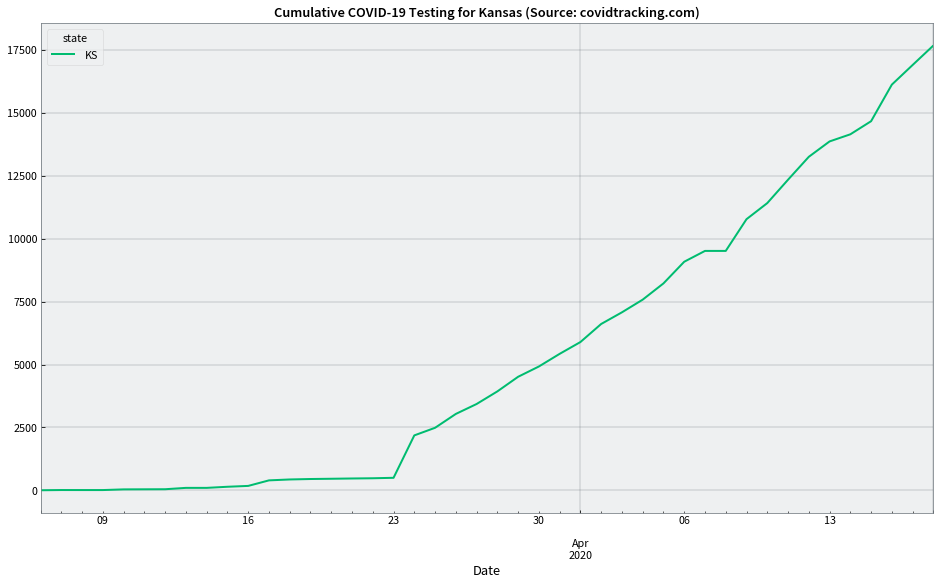

In [150]:
figsize(16, 9)
tests_df[tests_df['state'].isin(['KS'])].groupby(['Date', 'state'])['total'].max().unstack('state').plot(kind='line',
                                                                                                                     title="Cumulative COVID-19 Testing for Kansas (Source: covidtracking.com)")

In [151]:
tests_df.dtypes

date                                      int64
state                                    object
positive                                float64
negative                                float64
pending                                 float64
hospitalizedCurrently                   float64
hospitalizedCumulative                  float64
inIcuCurrently                          float64
inIcuCumulative                         float64
onVentilatorCurrently                   float64
onVentilatorCumulative                  float64
recovered                               float64
hash                                     object
dateChecked                 datetime64[ns, UTC]
death                                   float64
hospitalized                            float64
total                                   float64
totalTestResults                        float64
posNeg                                  float64
fips                                     object
deathIncrease                           

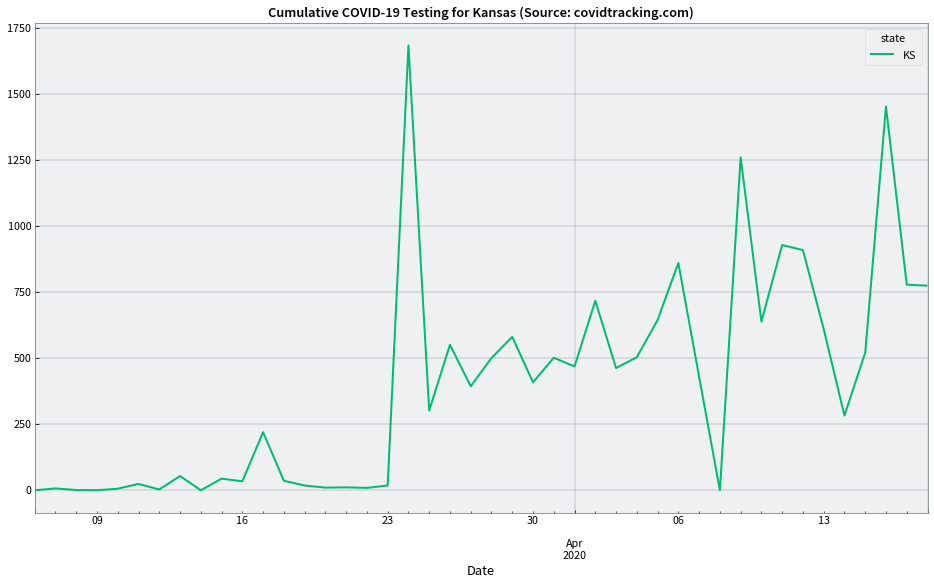

In [152]:
figsize(16, 9)
tests_df[tests_df['state'].isin(['KS'])].groupby(['Date', 'state'])['totalTestResultsIncrease'].sum().unstack('state').plot(kind='line',
                                                                                                                     title="Cumulative COVID-19 Testing for Kansas (Source: covidtracking.com)")

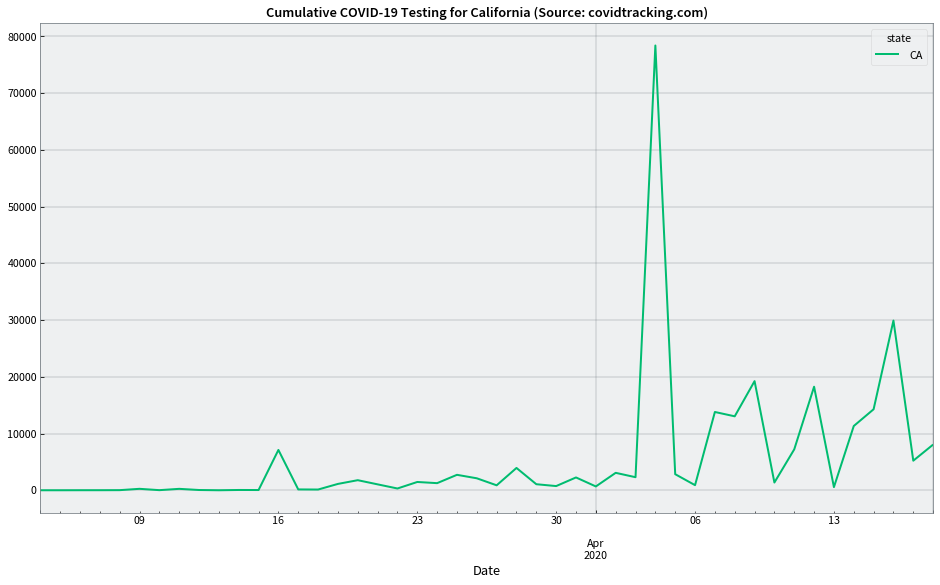

In [153]:
figsize(16, 9)
tests_df[tests_df['state'].isin(['CA'])].groupby(['Date', 'state'])['totalTestResultsIncrease'].sum().unstack('state').plot(kind='line',
                                                                                                                     title="Cumulative COVID-19 Testing for California (Source: covidtracking.com)")

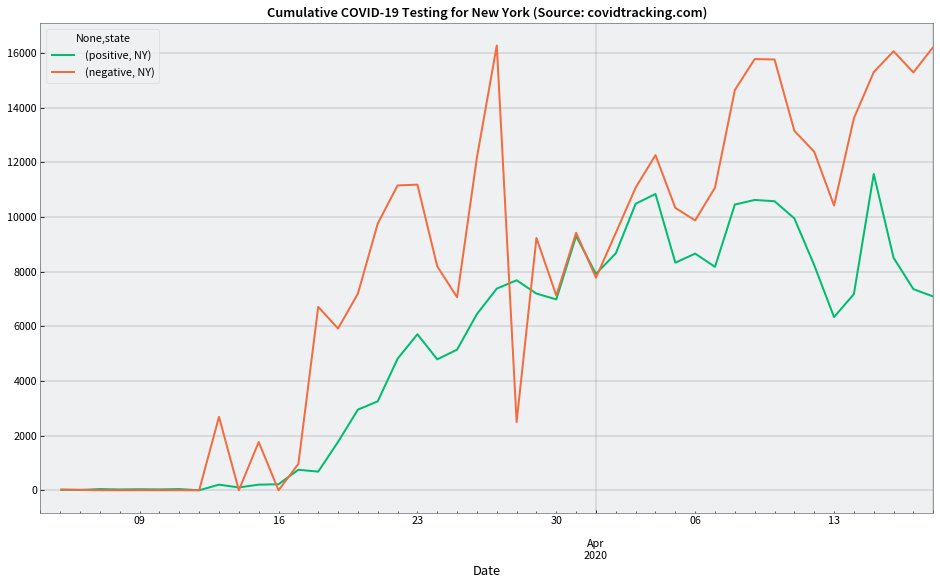

In [154]:
figsize(16, 9)
tests_df[tests_df['state'].isin(['NY'])].groupby(['Date', 'state'])[['positive', 'negative']].max().diff().unstack('state').plot(kind='line',
                                                                                                                     title="Cumulative COVID-19 Testing for New York (Source: covidtracking.com)")

In [155]:
tests_df.dtypes

date                                      int64
state                                    object
positive                                float64
negative                                float64
pending                                 float64
hospitalizedCurrently                   float64
hospitalizedCumulative                  float64
inIcuCurrently                          float64
inIcuCumulative                         float64
onVentilatorCurrently                   float64
onVentilatorCumulative                  float64
recovered                               float64
hash                                     object
dateChecked                 datetime64[ns, UTC]
death                                   float64
hospitalized                            float64
total                                   float64
totalTestResults                        float64
posNeg                                  float64
fips                                     object
deathIncrease                           

In [156]:
((tests_df[tests_df['state'] == 'NY'].groupby('Date')['hospitalized'].max() / tests_df[tests_df['state'] == 'NY'].groupby('Date')['total'].max()) * 100)

Date
2020-03-04         NaN
2020-03-05         NaN
2020-03-06         NaN
2020-03-07         NaN
2020-03-08         NaN
2020-03-09         NaN
2020-03-10         NaN
2020-03-11         NaN
2020-03-12         NaN
2020-03-13         NaN
2020-03-14         NaN
2020-03-15         NaN
2020-03-16         NaN
2020-03-17         NaN
2020-03-18         NaN
2020-03-19         NaN
2020-03-20         NaN
2020-03-21    3.527962
2020-03-22    3.214931
2020-03-23    3.365735
2020-03-24    3.543333
2020-03-25    3.677075
2020-03-26    5.605058
2020-03-27    5.849622
2020-03-28    6.447600
2020-03-29    7.005686
2020-03-30    7.358367
2020-03-31    7.751016
2020-04-01    8.315828
2020-04-02    8.711318
2020-04-03    9.095655
2020-04-04    9.302203
2020-04-05    9.293370
2020-04-06    9.414577
2020-04-07    9.434567
2020-04-08    9.429472
2020-04-09    9.341360
2020-04-10    9.289159
2020-04-11    9.224681
2020-04-12    9.227450
2020-04-13    8.928896
2020-04-14    9.256065
2020-04-15    8.783260
2020-0

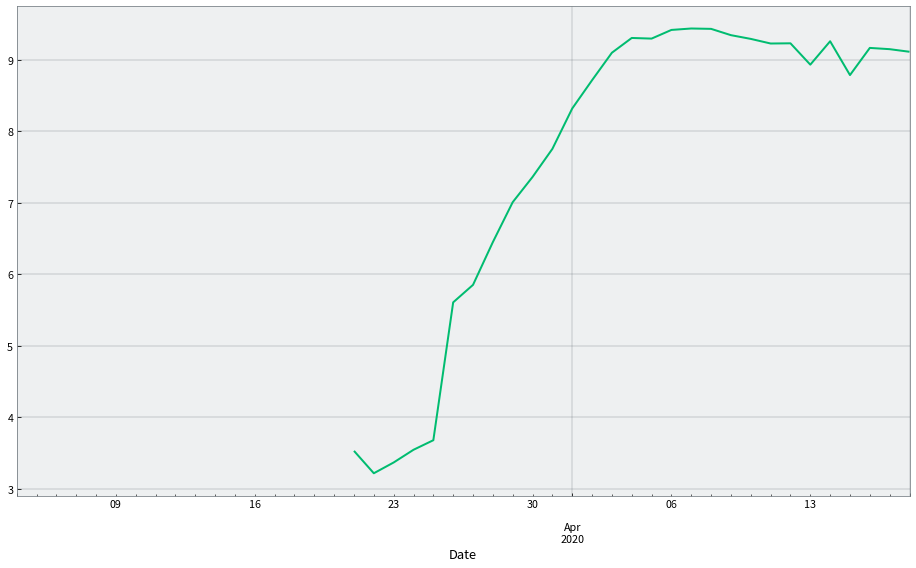

In [157]:
((tests_df[tests_df['state'] == 'NY'].groupby('Date')['hospitalized'].max() / tests_df[tests_df['state'] == 'NY'].groupby('Date')['total'].max()) * 100).plot(kind='line')

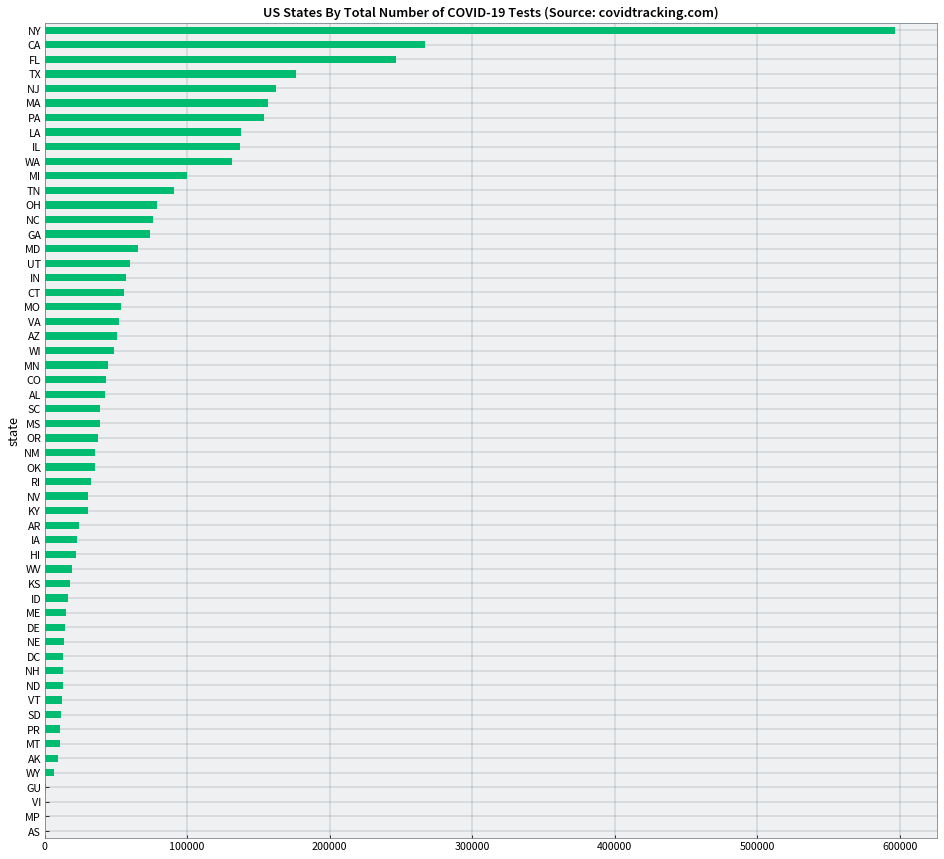

In [158]:
figsize(16,15)
tests_df.groupby('state')['total'].max().sort_values().plot(kind='barh',
                                                            title="US States By Total Number of COVID-19 Tests (Source: covidtracking.com)")

In [159]:
tests_df[tests_df['Date'] >= '2020-03-23'].groupby('state')['totalTestResultsIncrease'].mean().sort_values()

state
AS        0.111111
MP        2.074074
VI       16.185185
GU       34.296296
WY      224.444444
AK      321.740741
PR      332.111111
MT      347.851852
SD      403.666667
VT      422.518519
NH      429.592593
ND      432.407407
DC      452.333333
ME      465.555556
NE      491.592593
DE      515.740741
ID      570.074074
KS      636.851852
WV      705.296296
IA      801.555556
HI      816.000000
AR      861.666667
NV     1041.222222
KY     1075.000000
NM     1142.000000
RI     1178.185185
OR     1279.925926
OK     1288.888889
SC     1376.740741
MS     1386.814815
CO     1435.444444
MN     1466.222222
AL     1516.148148
WI     1538.740741
VA     1799.777778
AZ     1874.481481
CT     1939.333333
MO     1974.074074
IN     2051.074074
UT     2083.518519
MD     2408.592593
NC     2584.185185
GA     2599.555556
OH     2898.777778
TN     3215.148148
MI     3367.296296
WA     3853.962963
IL     4780.888889
LA     4981.518519
PA     5500.814815
MA     5581.518519
NJ     5936.851852
TX    

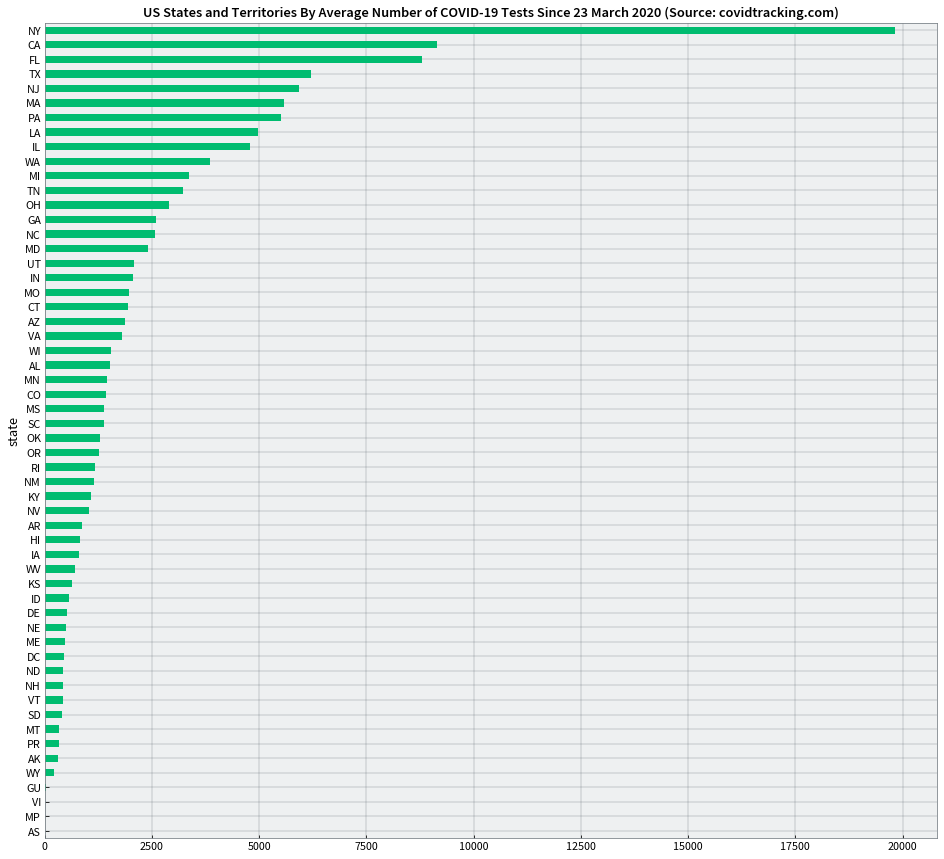

In [160]:
tests_df[tests_df['Date'] >= '2020-03-23'].groupby('state')['totalTestResultsIncrease'].mean().sort_values().plot(kind='barh',
                                                                                                                  title="US States and Territories By Average Number of COVID-19 Tests Since 23 March 2020 (Source: covidtracking.com)")

In [161]:
tests_df.groupby('state')['positive'].max().sort_values()

state
AS         0.0
MP        14.0
VI        53.0
GU       136.0
WY       305.0
AK       314.0
MT       426.0
ND       528.0
HI       553.0
WV       785.0
VT       803.0
ME       847.0
PR      1118.0
NE      1138.0
NH      1287.0
SD      1542.0
ID      1655.0
NM      1711.0
AR      1739.0
KS      1790.0
OR      1844.0
MN      2213.0
DE      2323.0
IA      2513.0
KY      2522.0
OK      2570.0
DC      2666.0
UT      2931.0
NV      3626.0
MS      3974.0
WI      4199.0
SC      4246.0
RI      4491.0
AL      4655.0
AZ      4719.0
MO      5517.0
NC      6140.0
TN      6762.0
VA      8053.0
CO      9047.0
OH      9939.0
IN     10641.0
WA     11445.0
MD     12308.0
CT     16809.0
GA     17669.0
TX     18260.0
LA     23580.0
FL     25269.0
CA     28963.0
IL     29160.0
MI     30791.0
PA     31069.0
MA     36372.0
NJ     81420.0
NY    236732.0
Name: positive, dtype: float64

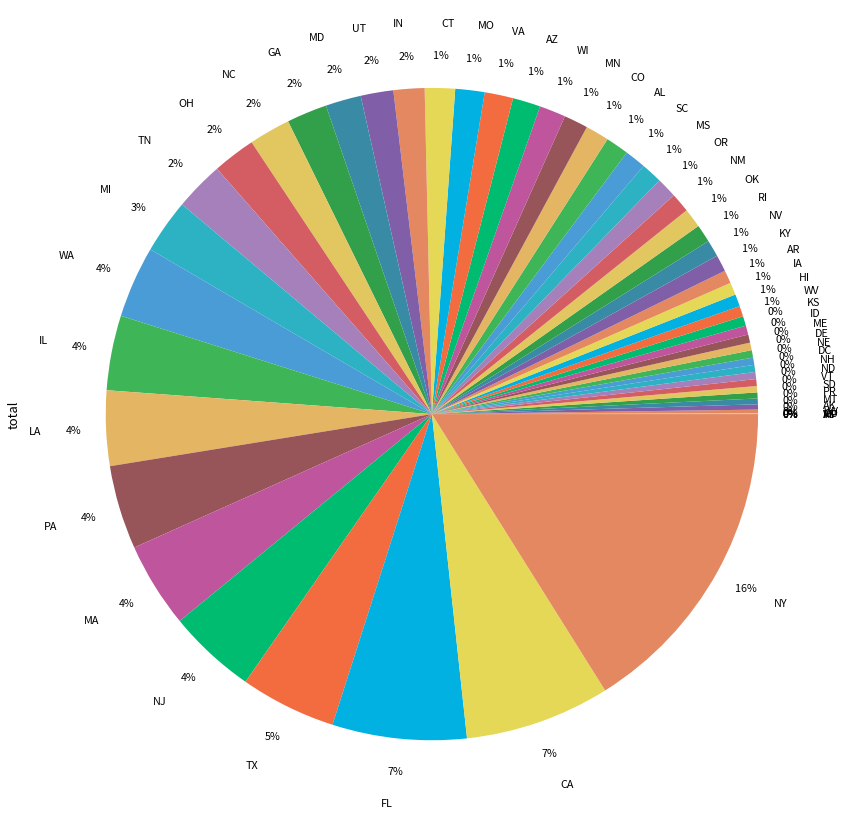

In [162]:
tests_df.groupby('state')['total'].max().sort_values().plot(kind='pie', autopct='%1.0f%%', pctdistance=1.1, labeldistance=1.2, legend=False,)

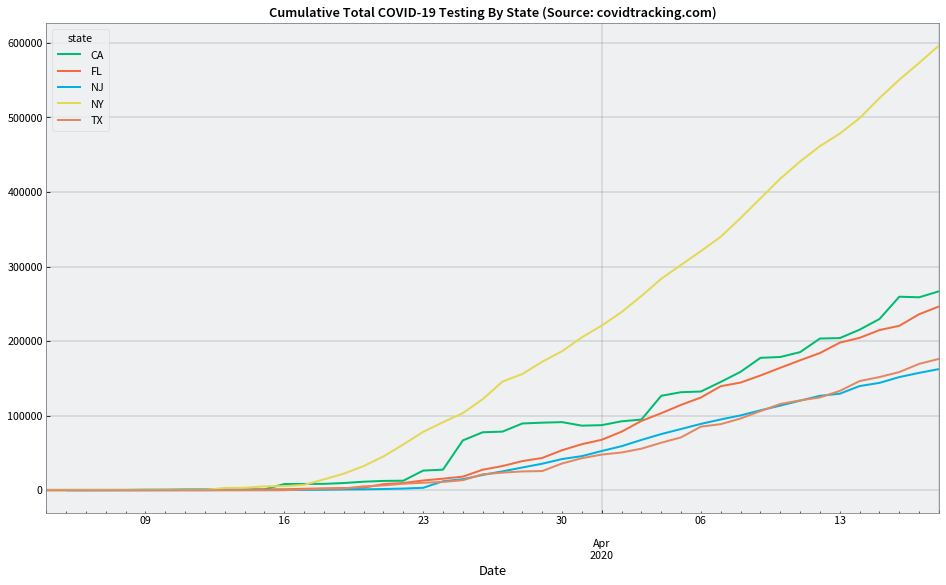

In [163]:
figsize(16, 9)
tests_df[tests_df['state'].isin(tests_df.groupby('state')['total'].max().sort_values()[-5:].index)].groupby(['Date', 'state'])['total'].max().unstack('state').plot(kind='line',
                                                                                                                                                                     title="Cumulative Total COVID-19 Testing By State (Source: covidtracking.com)")

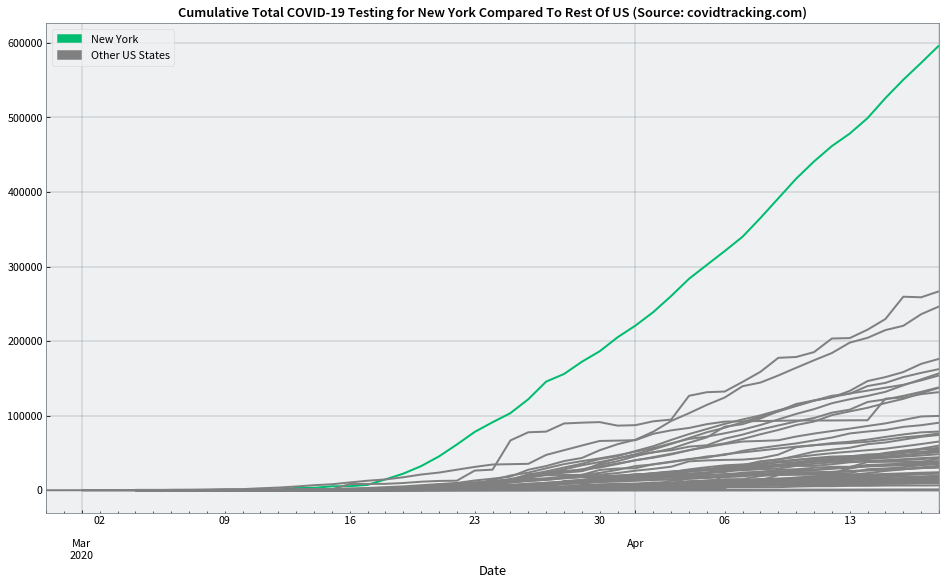

In [164]:


figsize(16, 9)
ax = tests_df[tests_df['state'] == 'NY'].groupby(['Date', 'state'])['total'].max().unstack('state').plot(kind='line',
                                                                                                         title="Cumulative Total COVID-19 Testing for New York Compared To Rest Of US (Source: covidtracking.com)")

tests_df[-(tests_df['state'] == 'NY')].groupby(['Date', 'state'])['total'].max().unstack('state').plot(kind='line',
                                                                                                       color="gray",
                                                                                                       legend=False,
                                                                                                       ax=ax)

patch = mpatches.Patch(color="gray", label="Other US States")
ax.legend(handles=[mpatches.Patch(color="#00bc70", label="New York"),
                   mpatches.Patch(color="gray", label="Other US States")])

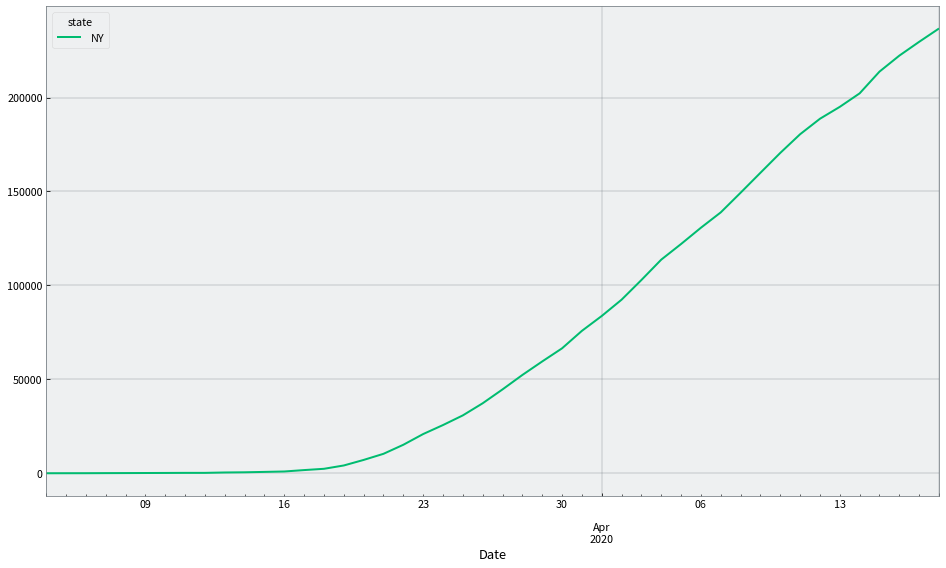

In [165]:
ax = tests_df[tests_df['state'] == 'NY'].groupby(['Date', 'state'])['positive'].max().unstack('state').plot(kind='line', color="#00bc70", label="Positive COVID-19 Tests")

In [166]:
tests_df['New York?'] = tests_df['state'].str.contains('NY')

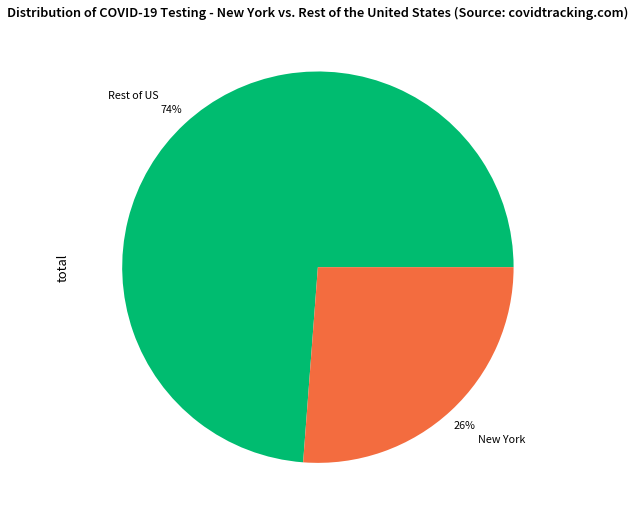

In [167]:
ax = tests_df[tests_df['Date'] == '2020-03-22'].groupby('New York?')['total'].sum().plot(kind='pie', autopct='%1.0f%%', pctdistance=1.1, labeldistance=1.2, legend=False,
                                                       title="Distribution of COVID-19 Testing - New York vs. Rest of the United States (Source: covidtracking.com)",
                                                       labels=['Rest of US', 'New York'])

In [168]:
tests_df[tests_df['Date'] == '2020-03-22'].groupby('New York?')['total'].sum()

New York?
False    172938.0
True      61401.0
Name: total, dtype: float64

In [169]:
tests_df.groupby(['Date', 'New York?'])['total'].sum().unstack('New York?').diff()

New York?,False,True
Date,,
2020-02-28,NaN,NaN
2020-02-29,9.0,NaN
2020-03-01,22.0,NaN
2020-03-02,13.0,NaN
2020-03-03,47.0,NaN
2020-03-04,893.0,NaN
2020-03-05,328.0,44.0
2020-03-06,758.0,239.0
2020-03-07,508.0,43.0


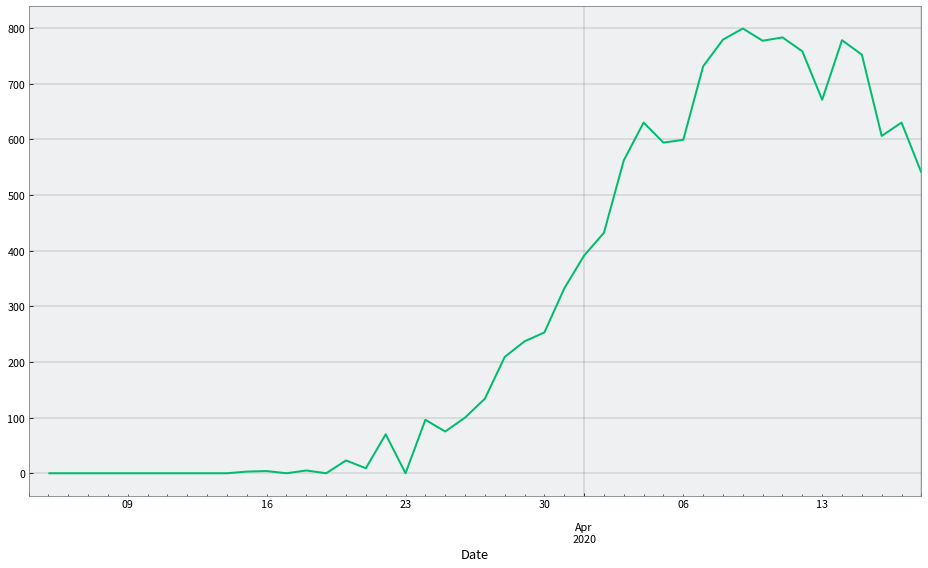

In [170]:
tests_df[tests_df['state'] == 'NY'].groupby('Date')['death'].sum().diff().plot(kind='line')

In [171]:
tests_df['Date'].max()

Timestamp('2020-04-18 00:00:00')

# Kansas

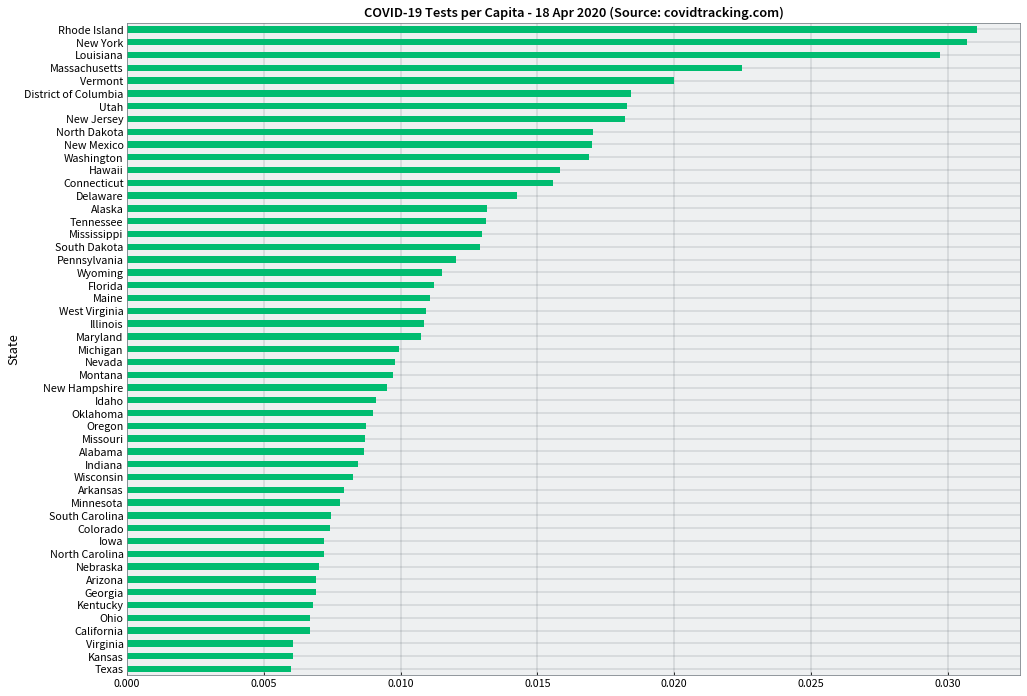

In [172]:
figsize(16, 12)
tests_df.groupby('State')['Tests per Capita'].max().sort_values()[:-4].plot(kind='barh',
                                                                            title="COVID-19 Tests per Capita - {0} (Source: covidtracking.com)".format(tests_df['Date'].max().strftime("%d %b %Y")))

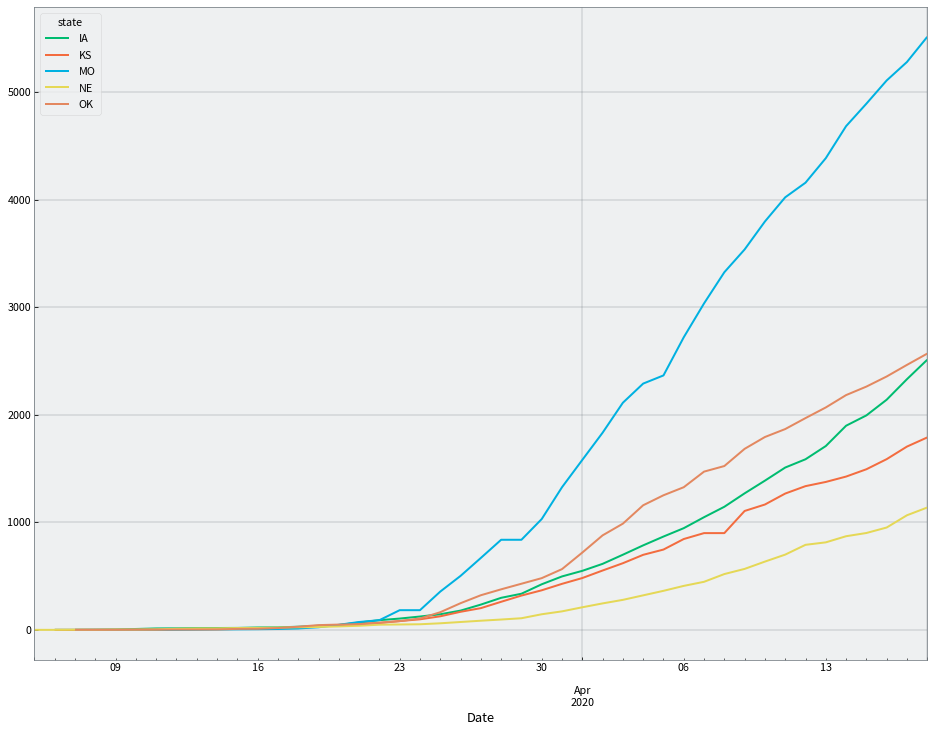

In [173]:
tests_df[tests_df['state'].isin(['KS', 'NE', 'OK', 'IA', 'MO'])].groupby(['Date', 'state'])['positive'].sum().unstack('state').plot(kind='line')

# Pennsylvania

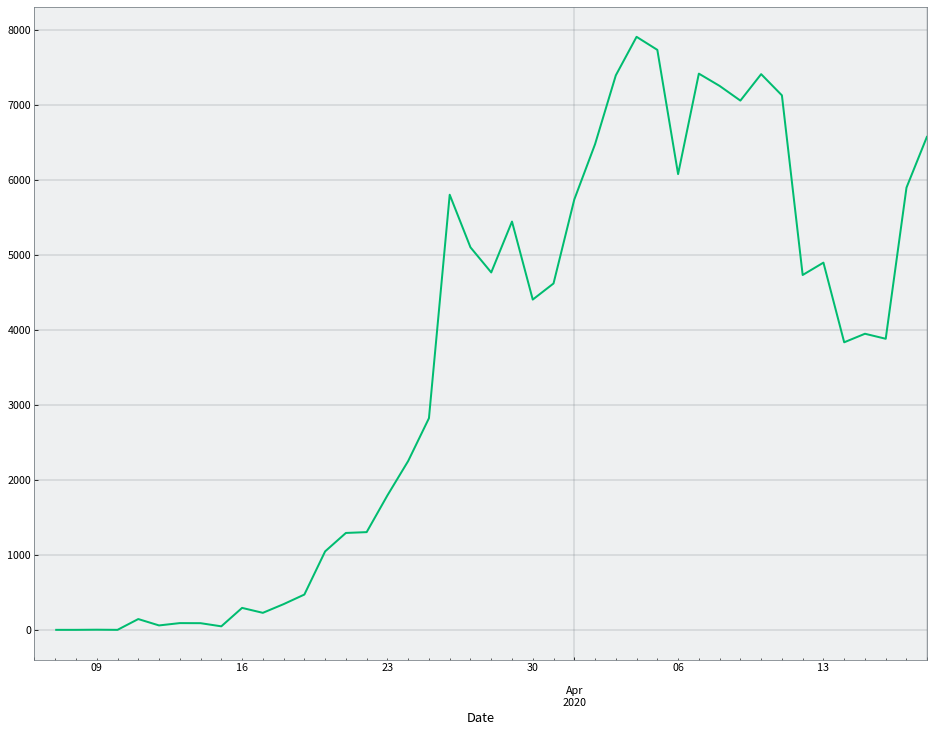

In [174]:
tests_df[tests_df['state'] == 'PA'].groupby('Date')['total'].max().diff().plot(kind='line')

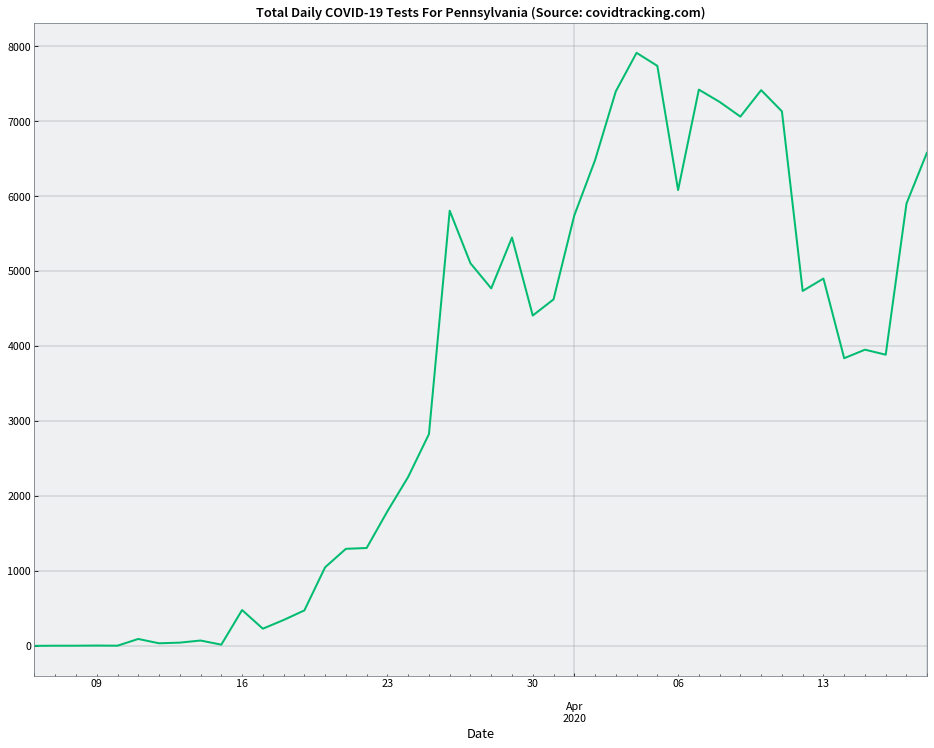

In [175]:
tests_df[tests_df['state'] == 'PA'].groupby('Date')['totalTestResultsIncrease'].sum().plot(kind='line',
                                                                                           title="Total Daily COVID-19 Tests For Pennsylvania (Source: covidtracking.com)") 